Train small classifier network

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys, glob
from bs4 import BeautifulSoup
from tqdm import tqdm
import random
import time

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [6]:
CLASSES_ORIG = ["with_mask", "without_mask", "mask_weared_incorrect"]
CLASSES_NAME = ["with_mask", "without_mask", "mask_worn_incorrectly"]

def parse(name):
    img_file = "dataset/images/{}.png".format(name)
    lab_file = "dataset/annotations/{}.xml".format(name)
    sample_file = "dataset/samples/{}.png".format(name)
    
    img = cv2.imread(img_file)
    
    img_orig = img.copy()
    
    with open(lab_file, "r") as f:
        labels = BeautifulSoup(f.read())
        
    labels_obj = []
        
    for l in labels.annotation.findAll("object"):
        class_name = l.findAll("name")[0].text
        assert class_name in CLASSES_ORIG
        labels_obj.append({
            "class": CLASSES_ORIG.index(class_name),
            "x0": int(l.bndbox.xmin.text),
            "y0": int(l.bndbox.ymin.text),
            "x1": int(l.bndbox.xmax.text),
            "y1": int(l.bndbox.ymax.text),
        })

    return img, labels_obj

def augment(img):
    w = img.shape[1]
    h = img.shape[0]
    
    x0, x1 = int(random.random() * 0.3 * w), -int(random.random() * 0.3 * w)-1
    i = img[int(random.random() * 0.3 * h):-int(random.random() * 0.3 * h),
               x0:x1]
    
    print(i.shape, w, x0, x1, img[:, x0:].shape, img[:, :x1].shape, img[:, x0:x1].shape)
    
    assert i.shape[0] > 1 and i.shape[1] > 1
    
    return i



In [7]:
names = sorted([os.path.splitext(os.path.basename(x))[0] for x in glob.glob("dataset/images/*.png")])

random.seed(42)
random.shuffle(names)

imgs = []
labels = []
for name in tqdm(names):
    img, label = parse(name)
    imgs.append(img)
    labels.append(label)

100%|██████████| 853/853 [00:14<00:00, 58.79it/s]


In [8]:
X = []
Y = []

for i, l in zip(imgs, labels):
    for y in l:
        X.append(i[y["y0"]:y["y1"], y["x0"]:y["x1"]])
        Y.append(y["class"])

"""for i, l in zip(imgs, labels):
    for y in l:
        X.append(augment(i[y["y0"]:y["y1"], y["x0"]:y["x1"]]))
        Y.append(y["class"])
"""

X = [cv2.resize(x, (32, 32)) for x in X]

assert len(X) == len(Y)

print(len(X))

X_train = X[:int(0.85 * len(X))]
Y_train = np.array(Y[:int(0.85 * len(Y))])

X_val = X[int(0.85 * len(X)):]
Y_val = np.array(Y[int(0.85 * len(Y)):])

print("Total:", len(X))
print("Train:", len(X_train))
print("Test:", len(X_val))

def onehot(x, size):
    arr = [0]*size
    arr[x] = 1
    return arr

SIZE = len(CLASSES_ORIG) # Temporary hack

X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0

#print(X_val[0], X_val.shape)

Y_train = np.array([onehot(y, SIZE) for y in Y_train])
Y_val = np.array([onehot(y, SIZE) for y in Y_val])

4072
Total: 4072
Train: 3461
Test: 611


In [9]:
Y_val[1]

array([1, 0, 0])

In [10]:
list(range(22))[4:-4]

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

with_mask


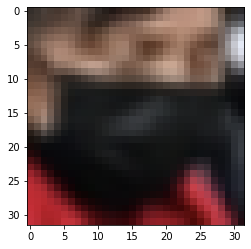

In [11]:
I = 700
plt.imshow(X_train[I][:, :, ::-1])
print(CLASSES_NAME[np.argmax(Y_train[I])])

In [12]:
BATCH_SIZE=64
EPOCHS=30

model = Sequential()
model.add(Conv2D(16, (3, 3), strides=(1, 1), padding="same", use_bias=False, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), strides=(1, 1), padding="same", use_bias=False, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), strides=(1, 1), padding="same", use_bias=False, activation="relu"))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(len(CLASSES_NAME), activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
          epochs=EPOCHS, shuffle=True, batch_size=BATCH_SIZE)

Train on 3461 samples, validate on 611 samples
Epoch 1/30
3461/3461 [==============================] - 3s 725us/sample - loss: 0.4156 - acc: 0.8547 - val_loss: 0.2356 - val_acc: 0.9296
Epoch 2/30
3461/3461 [==============================] - 2s 676us/sample - loss: 0.2181 - acc: 0.9361 - val_loss: 0.1809 - val_acc: 0.9444
Epoch 3/30
3461/3461 [==============================] - 2s 681us/sample - loss: 0.1694 - acc: 0.9463 - val_loss: 0.1813 - val_acc: 0.9509
Epoch 4/30
3461/3461 [==============================] - 2s 674us/sample - loss: 0.1681 - acc: 0.9454 - val_loss: 0.1680 - val_acc: 0.9509
Epoch 5/30
3461/3461 [==============================] - 2s 680us/sample - loss: 0.1461 - acc: 0.9483 - val_loss: 0.2288 - val_acc: 0.9214
Epoch 6/30
3461/3461 [==============================] - 2s 678us/sample - loss: 0.1412 - acc: 0.9500 - val_loss: 0.1532 - val_acc: 0.9460
Epoch 7/30
3461/3461 [==============================] - 2s 680us/sample - loss: 0.1134 - acc: 0.9610 - val_loss: 0.1552 - val

In [13]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    # https://stackoverflow.com/questions/45466020/how-to-export-keras-h5-to-tensorflow-pb
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [15]:
model.save("model.h5")

f = freeze_session(tf.keras.backend.get_session(), output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(f, ".", "model-frozen.pb", as_text=False)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 49 variables.
INFO:tensorflow:Converted 49 variables to const ops.


'./model-frozen.pb'

In [20]:
# So small, not worth the overhead of using DPU
infer_model = tf.lite.TFLiteConverter.from_frozen_graph("model-frozen.pb",
                                                       input_arrays=[i.op.name for i in model.inputs],
                                                       output_arrays=[out.op.name for out in model.outputs])

with open("model.tflite", "wb") as f:
    f.write(infer_model.convert())



In [22]:
# Test inferences

(32, 32, 3)
0.0034859180450439453
[100   0   0]
with_mask


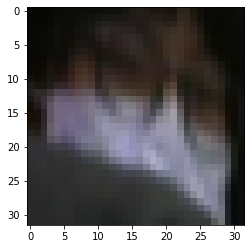

In [56]:
img = X_val[8]

"""
img = cv2.imread("/home/anish/temp/img.png")
print(img.shape)
img = cv2.resize(img, (32, 32)) / 255.0
"""
print(img.shape)
plt.imshow(img[:, :, ::-1])

interpreter = tf.lite.Interpreter(model_path="./model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]["index"], img[None, :].astype(np.float32))

start = time.time()
interpreter.invoke()
stop = time.time()
print(stop-start)

output_data = interpreter.get_tensor(output_details[0]["index"])
results = np.squeeze(output_data)

# with / without / incorrect
print(np.round(results*100).astype(np.uint32))
print(CLASSES_NAME[np.argmax(results)])